<a href="https://colab.research.google.com/github/dookda/cmu_water_balance/blob/main/lstm_rain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: get folder from google drive

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [11]:
# prompt: get folder in drive
import os
# Navigate to a directory in your drive
!ls "/content/drive/My Drive/_GEE/rain/"

# current workspace
os.chdir("/content/drive/My Drive/_GEE/rain/")

rainfall_timeseries.csv


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/My Drive/_GEE/rain/rainfall_timeseries.csv", parse_dates=["date"])
df = df.sort_values(by="date")
# df = df.set_index("date")

rain = df["rainfall"].fillna(0).values
dates = df["date"].values
print(rain)

# Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rain = scaler.fit_transform(rain.reshape(-1, 1))

print(rain)

In [ ]:
def create_sequences(data, seq_len):
  X,y = [],[]
  for i in range(len(data)-seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+seq_len])
  return np.array(X), np.array(y)

sequence_length = 12
X,y = create_sequences(rain, sequence_length)
print(X.shape, y.shape)
print(X)
# print(y)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.1104 - val_loss: 0.1252
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1061 - val_loss: 0.1052
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0779 - val_loss: 0.0880
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0684 - val_loss: 0.0729
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0591 - val_loss: 0.0618
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0463 - val_loss: 0.0575
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0456 - val_loss: 0.0572
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0524 - val_loss: 0.0563
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0508 - val_loss: 0.0562
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0480 - val_loss: 0.0568
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0509 - val_loss: 0.0565
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0464 - val_loss: 0.0557


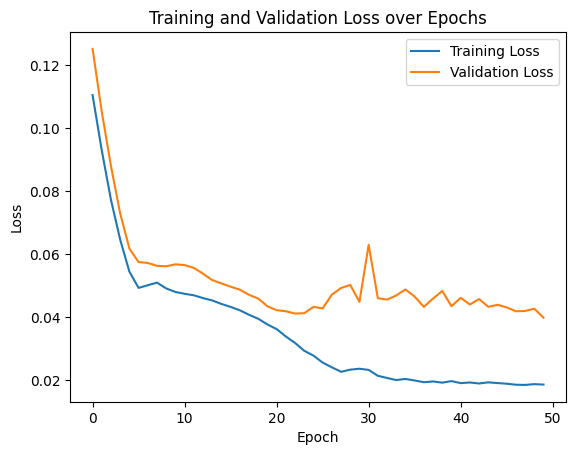

In [25]:
# prompt: show loss as chart

import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Predicted rainfall for the next month: 13.41 mm


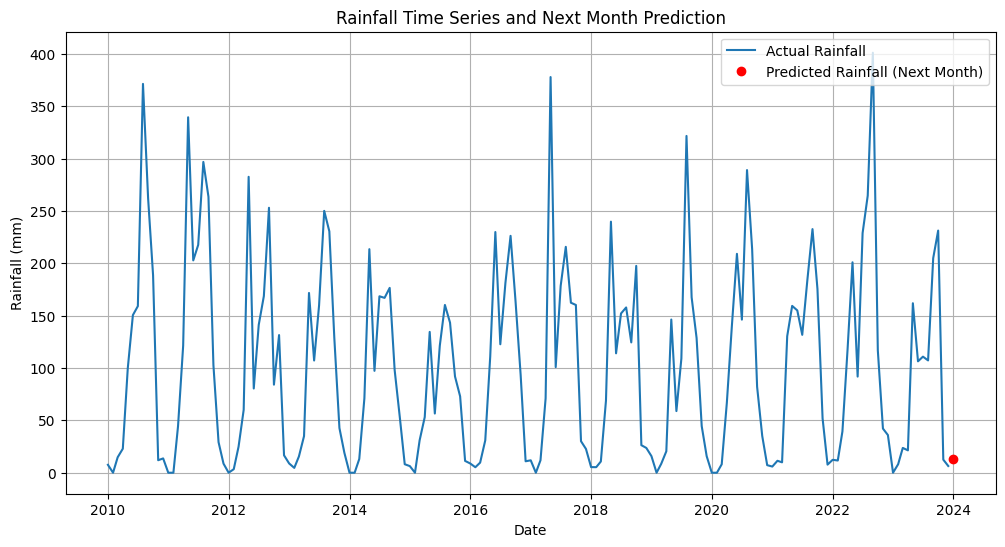

In [26]:
# prompt: forecasting next month's rainfall and show as chart

# Make predictions for the next month
future_sequence = rain[-sequence_length:].reshape(1, sequence_length, 1)
predicted_scaled = model.predict(future_sequence)
predicted_rainfall = scaler.inverse_transform(predicted_scaled)[0][0]

print(f"Predicted rainfall for the next month: {predicted_rainfall:.2f} mm")

# Prepare data for the chart
# Extend the dates by one month
last_date = pd.to_datetime(dates[-1])
next_month = last_date + pd.DateOffset(months=1)

# Create a series for actual rainfall
actual_series = pd.Series(scaler.inverse_transform(rain).flatten(), index=pd.to_datetime(dates))

# Create a series for the predicted rainfall
predicted_series = pd.Series([predicted_rainfall], index=[next_month])

# Combine actual and predicted for plotting
combined_series = pd.concat([actual_series, predicted_series])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(actual_series.index, actual_series.values, label='Actual Rainfall')
plt.plot(predicted_series.index, predicted_series.values, 'ro', label='Predicted Rainfall (Next Month)') # 'ro' for red circle marker
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall Time Series and Next Month Prediction')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Predicted rainfall for the next year:
2024-01-01: 13.41 mm
2024-02-01: 15.68 mm
2024-03-01: 31.81 mm
2024-04-01: 59.10 mm
2024-05-01: 96.55 mm
2024-06-01: 129.32 mm
2024-07-01: 167.07 mm
2024-08-01: 200.91 mm
2024-09-01: 224.52 mm
2024-10-01: 172.01 mm
2024-11-01: 47.66 mm
2024-12-01: 9.23 mm


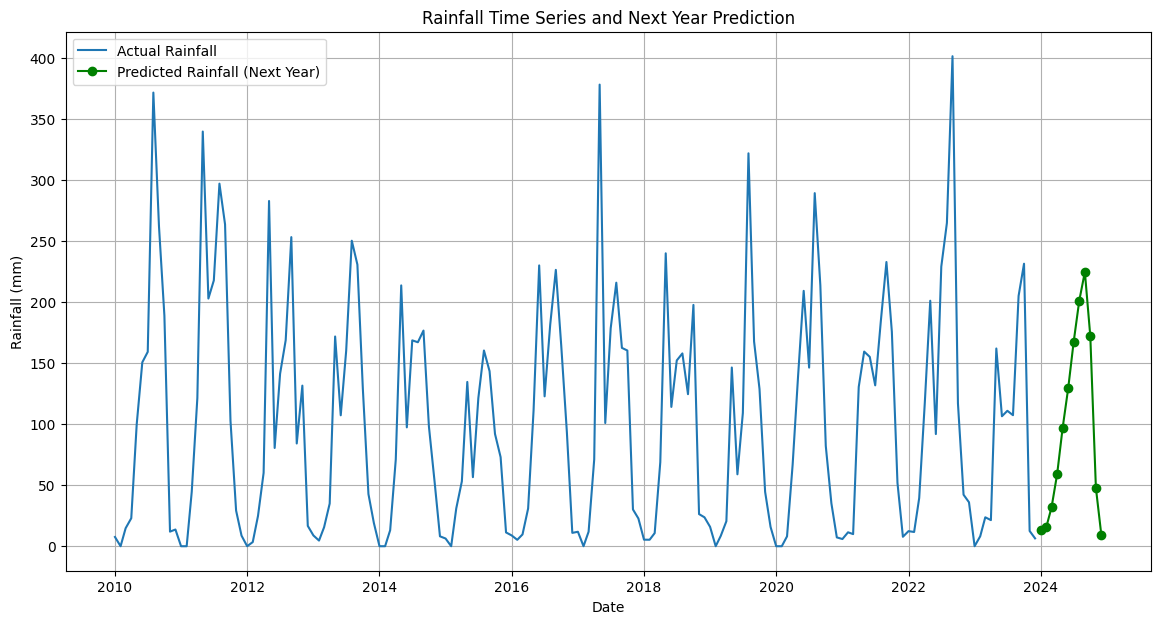

In [27]:
# prompt: predict for next year

# Extend the dates to cover the next year (12 months)
last_date = pd.to_datetime(dates[-1])
future_dates = pd.date_range(start=last_date, periods=13, freq='MS')[1:] # Start from the month *after* the last date, include 12 months

# Prepare the initial sequence for prediction (the last sequence from the training data)
current_sequence = rain[-sequence_length:].reshape(1, sequence_length, 1)

# List to store future predictions
future_predictions_scaled = []

# Predict the next 12 months
for _ in range(12):
  predicted_scaled_next = model.predict(current_sequence)
  future_predictions_scaled.append(predicted_scaled_next[0][0])

  # Update the current sequence by removing the first element and adding the new prediction
  current_sequence = np.append(current_sequence[:, 1:, :], predicted_scaled_next.reshape(1, 1, 1), axis=1)

# Inverse transform the scaled predictions
predicted_rainfall_next_year = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1)).flatten()

# Print the predictions
print("\nPredicted rainfall for the next year:")
for date, rainfall in zip(future_dates, predicted_rainfall_next_year):
  print(f"{date.strftime('%Y-%m-%d')}: {rainfall:.2f} mm")


# Prepare data for the chart
# Create a series for actual rainfall
actual_series = pd.Series(scaler.inverse_transform(rain).flatten(), index=pd.to_datetime(dates))

# Create a series for the predicted rainfall for the next year
predicted_series_next_year = pd.Series(predicted_rainfall_next_year, index=future_dates)

# Combine actual and predicted for plotting
combined_series_next_year = pd.concat([actual_series, predicted_series_next_year])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(actual_series.index, actual_series.values, label='Actual Rainfall')
plt.plot(predicted_series_next_year.index, predicted_series_next_year.values, 'go-', label='Predicted Rainfall (Next Year)') # 'go-' for green circle marker and line
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall Time Series and Next Year Prediction')
plt.legend()
plt.grid(True)
plt.show()